In [52]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import numpy as np
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

from textwrap import wrap

In [53]:
bls_work_stoppages_file_location = 'Dataset/work_stoppages_BLS.csv'  

# The CSV records numbers with commas in them (e.g.: 1,230,000 as opposed to 123000). 
# Pandas cannot interpret those natively, so here's a function to strip them out and convert them to integers
def read_numeric_cell_with_commas(cell):
    try:
        return int(cell.replace(',',''))
    except:
        return 0

# Strikes that involved multiple states, industries, and/or unions often recorded them as a comma seperated list of strings. 
# If we want to groupby based on those variables later, we'll want to be able to break those rows into multiples later
# This makes that easier
split_string_by_comma = lambda s: pd.Series(str(s).split(',')).map(lambda s_prime: s_prime.strip())

# specifying certain types as categories to improve performance
dtypes = {
    'Organizations involved': 'category',
    'Ownership': 'category',
    'Industry code[1]': 'category'
}

# renaming certain columns for easier reference later
renamed_columns = {
    'Days idle, cumulative for this work stoppage[3]': 'Cumulative days idle',
    'Number of workers[2]': 'Number of workers',
    'Work stoppage beginning date': 'Beginning date',
    'Work stoppage ending date': 'Ending date',
    'Industry code[1]': 'Industry code'
}

# formatting certain columns for easier manipulation later on
column_converters = {
    'States': split_string_by_comma,
    'Union acronym': split_string_by_comma,
    'Days idle, cumulative for this work stoppage[3]': read_numeric_cell_with_commas, 
    'Number of workers[2]': read_numeric_cell_with_commas
}


other_columns_to_use = ['States', 'Union acronym']


bls_dataframe = pd.read_csv(bls_work_stoppages_file_location, 
    dtype=dtypes, 
    usecols=list(dtypes) + list(renamed_columns) + other_columns_to_use, 
    parse_dates=['Work stoppage beginning date','Work stoppage ending date'],
    converters=column_converters)

bls_dataframe = bls_dataframe.rename(columns=renamed_columns)

# Adding calculated columns we'll want to play with later
bls_dataframe['Year'] = bls_dataframe['Beginning date'].map(lambda x: x.year)
bls_dataframe['Length (days)'] = bls_dataframe.apply(lambda x: (x['Ending date'] - x['Beginning date']).days, axis=1)

bls_dataframe.head()



,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days)
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 TX 5...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0


In [54]:
# BLS records industries as numeric codes, so I went to their website to find a CSV indicating what they all were.
# I then joined the two together so our data frame could have human-readable industry names

bls_industry_codes_file_location = 'Dataset/bls_naics_2022_titles_descriptions_exploded.csv'

industry_codes_df = pd.read_csv(bls_industry_codes_file_location, usecols=['2022 NAICS','2022 NAICS Short Title'], dtype={'2022 NAICS' : 'string'})

industry_codes_df = industry_codes_df.rename(columns={'2022 NAICS': 'Industry code', '2022 NAICS Short Title': 'Industry Name'})
industry_codes_df = industry_codes_df.set_index('Industry code')

# There are codes for over 200 unique industries in the work stoppage data, which is impractically large for most data visualizations
# that would analyze based on it. However, BLS industry codes are hierarchical, with the first two digits corresponding to a top-level
# category. There are only a dozen or so of these, which is much more manageable, so we will base our join on that
bls_dataframe['Industry category code'] = bls_dataframe['Industry code'].map(lambda x: x[:2])
bls_dataframe = bls_dataframe.join(industry_codes_df, on='Industry category code').rename(columns={'Industry Name': 'Industry'})
bls_dataframe.head()

,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days),Industry category code,Industry
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 TX 5...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0,44,Retail Trade
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0,33,Manufacturing
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0,33,Manufacturing
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0,48,Transportation and Warehousing


In [55]:
# Some strikes affected more than one state at once; for example the Boeing strike of 2008 affected Washington, Oregon, and Kansas
# This is recorded in the CSV as a single row, with the States column saying "WA, OR, KS". If we want to do a groupby based on states, 
# we'll want to split (or 'explode') that into three mostly-identical rows, one for each state.
bls_dataframe_exploded_by_states = bls_dataframe.explode(column='States')

# Some strikes don't list a state, or simply say things like 'Interstate' or 'East coast states.' We can't use that to build choropleths,
# So we'll have to exclude these
bls_dataframe_exploded_by_states = bls_dataframe_exploded_by_states[bls_dataframe_exploded_by_states['States'].str.len() == 2]

bls_dataframe_exploded_by_states

,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days),Industry category code,Industry
0,Association of National Advertisers; American ...,AR,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
0,Association of National Advertisers; American ...,MA,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
0,Association of National Advertisers; American ...,IL,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
0,Association of National Advertisers; American ...,OH,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
0,Association of National Advertisers; American ...,TX,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,"Queen of the Valley Medical Center, Sutter Tra...",CA,Private industry,622110,0 CNA 1 NNU dtype: object,2014-08-14,2014-08-15,1000,1000,2014,1.0,62,Health Care and Social Assistance
604,"Port Authority of New York and New Jersey, New...",NY,Local government,488310,0 ILA dtype: object,2016-01-29,2016-01-29,1000,1000,2016,0.0,48,Transportation and Warehousing
604,"Port Authority of New York and New Jersey, New...",NJ,Local government,488310,0 ILA dtype: object,2016-01-29,2016-01-29,1000,1000,2016,0.0,48,Transportation and Warehousing
605,Charter Communications Inc.,NY,Private industry,517110,0 IBEW dtype: object,2017-03-28,NaT,1800,0,2017,NaN,51,Information


In [56]:
grouped_by_state = bls_dataframe_exploded_by_states.groupby('States').agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean'],
    'Length (days)': ['mean']
}).reset_index(names=['States'])

grouped_by_state.columns = grouped_by_state.columns.map(' '.join)
grouped_by_state = grouped_by_state.rename(columns={'States ' : 'State', 'Number of workers count' : 'Number of strikes'})

grouped_by_state


,State,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean,Length (days) mean
0,AK,3900,1950.000000,2,12700,6.350000e+03,4.000000
1,AL,56900,4741.666667,12,1484000,1.236667e+05,51.727273
2,AR,137900,45966.666667,3,17320000,5.773333e+06,72.000000
3,AZ,91800,15300.000000,6,1058400,1.764000e+05,82.500000
4,CA,1101500,7596.551724,145,27450900,1.893166e+05,14.696552
5,CO,264900,18921.428571,14,22296100,1.592579e+06,71.428571
6,CT,109600,7306.666667,15,740500,4.936667e+04,14.066667
7,DC,246300,30787.500000,8,18494800,2.311850e+06,53.125000
8,DE,89300,29766.666667,3,982500,3.275000e+05,9.666667
9,FL,169600,24228.571429,7,17562200,2.508886e+06,49.428571


In [57]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of strikes', 
    hover_name='Number of strikes',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='# strikes by state')
fig.show()

In [58]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers mean', 
    hover_name='State',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Average # Striking Workers by State')
fig.show()

In [59]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers sum', 
    hover_name='State',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Total # Striking Workers by State')
fig.show()

In [60]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle sum', 
    hover_name='Cumulative days idle sum',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Cumulative days idle')
fig.show()

In [61]:
filtered_df = bls_dataframe_exploded_by_states[bls_dataframe_exploded_by_states['Cumulative days idle'] < 10000000]

grouped_by_state_filtered = filtered_df.groupby('States').agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['States'])

grouped_by_state_filtered.columns = grouped_by_state_filtered.columns.map(' '.join)
grouped_by_state_filtered = grouped_by_state_filtered.rename(columns={'States ' : 'State', 'Number of workers count' : 'Number of strikes'})

grouped_by_state_filtered


,State,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,AK,3900,1950.000000,2,12700,6350.000000
1,AL,56900,4741.666667,12,1484000,123666.666667
2,AR,2900,1450.000000,2,40000,20000.000000
3,AZ,91800,15300.000000,6,1058400,176400.000000
4,CA,966500,6711.805556,144,10170900,70631.250000
5,CO,129900,9992.307692,13,5016100,385853.846154
6,CT,109600,7306.666667,15,740500,49366.666667
7,DC,111300,15900.000000,7,1214800,173542.857143
8,DE,89300,29766.666667,3,982500,327500.000000
9,FL,34600,5766.666667,6,282200,47033.333333


In [62]:
fig = px.choropleth(grouped_by_state_filtered, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle sum', 
    hover_name='Cumulative days idle sum',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Cumulative days idle (filter out SAG-AFTRA)')
fig.show()

In [63]:

fig = px.choropleth(grouped_by_state_filtered, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title=' Avg Cumulative days idle (filter out SAG-AFTRA)')
fig.show()

In [64]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Average length of strike by state')
fig.show()

In [65]:
grouped_by_ownership = bls_dataframe.groupby(['Ownership']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Ownership'])

grouped_by_ownership.columns = grouped_by_ownership.columns.map(' '.join)
grouped_by_ownership = grouped_by_ownership.rename(columns={'Ownership ' : 'Ownership', 'Number of workers count' : 'Number of strikes'})

grouped_by_ownership

C:\Users\emmaf\AppData\Local\Temp\ipykernel_26592\3362711432.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Ownership,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,Local government,574200,5416.981132,106,3077200,29030.188679
1,Private industry,3194800,7115.367483,449,77066900,171641.202673
2,State and local government,15800,15800.000000,1,136500,136500.000000
3,State government,851000,17020.000000,50,3031100,60622.000000


Text(0.5, 1.0, '# Strikes by Ownership type')

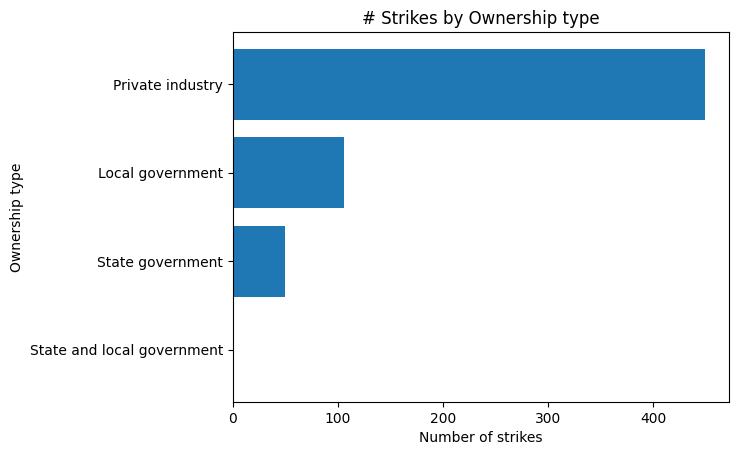

In [66]:
df_sorted = grouped_by_ownership.sort_values(by='Number of strikes', ascending=True)
plt.barh(df_sorted['Ownership'], df_sorted['Number of strikes'])
plt.xlabel('Number of strikes')
plt.ylabel('Ownership type')
plt.title('# Strikes by Ownership type')

In [67]:
grouped_by_industry = bls_dataframe.groupby(['Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Industry'])

grouped_by_industry.columns = grouped_by_industry.columns.map(' '.join)
grouped_by_industry = grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})
# grouped_by_industry[grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services']['Industry'] = 'Admin Support'
grouped_by_industry.loc[grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'
grouped_by_industry

,Industry,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,Accommodation and Food Services,44000,4400.000000,10,751100,7.511000e+04
1,Admin Support,41100,3425.000000,12,397000,3.308333e+04
2,"Arts, Entertainment, and Recreation",3400,1700.000000,2,184600,9.230000e+04
3,Construction,151800,2448.387097,62,1414500,2.281452e+04
4,Educational Services,939400,9585.714286,98,4212100,4.298061e+04
5,Finance and Insurance,7500,1875.000000,4,173600,4.340000e+04
6,Health Care and Social Assistance,574900,6051.578947,95,2078400,2.187789e+04
7,Information,486300,23157.142857,21,5583700,2.658905e+05
8,Manufacturing,1124000,6771.084337,166,28180200,1.697602e+05
9,"Mining, Quarrying, and Oil and Gas Extraction",41500,4150.000000,10,3393100,3.393100e+05


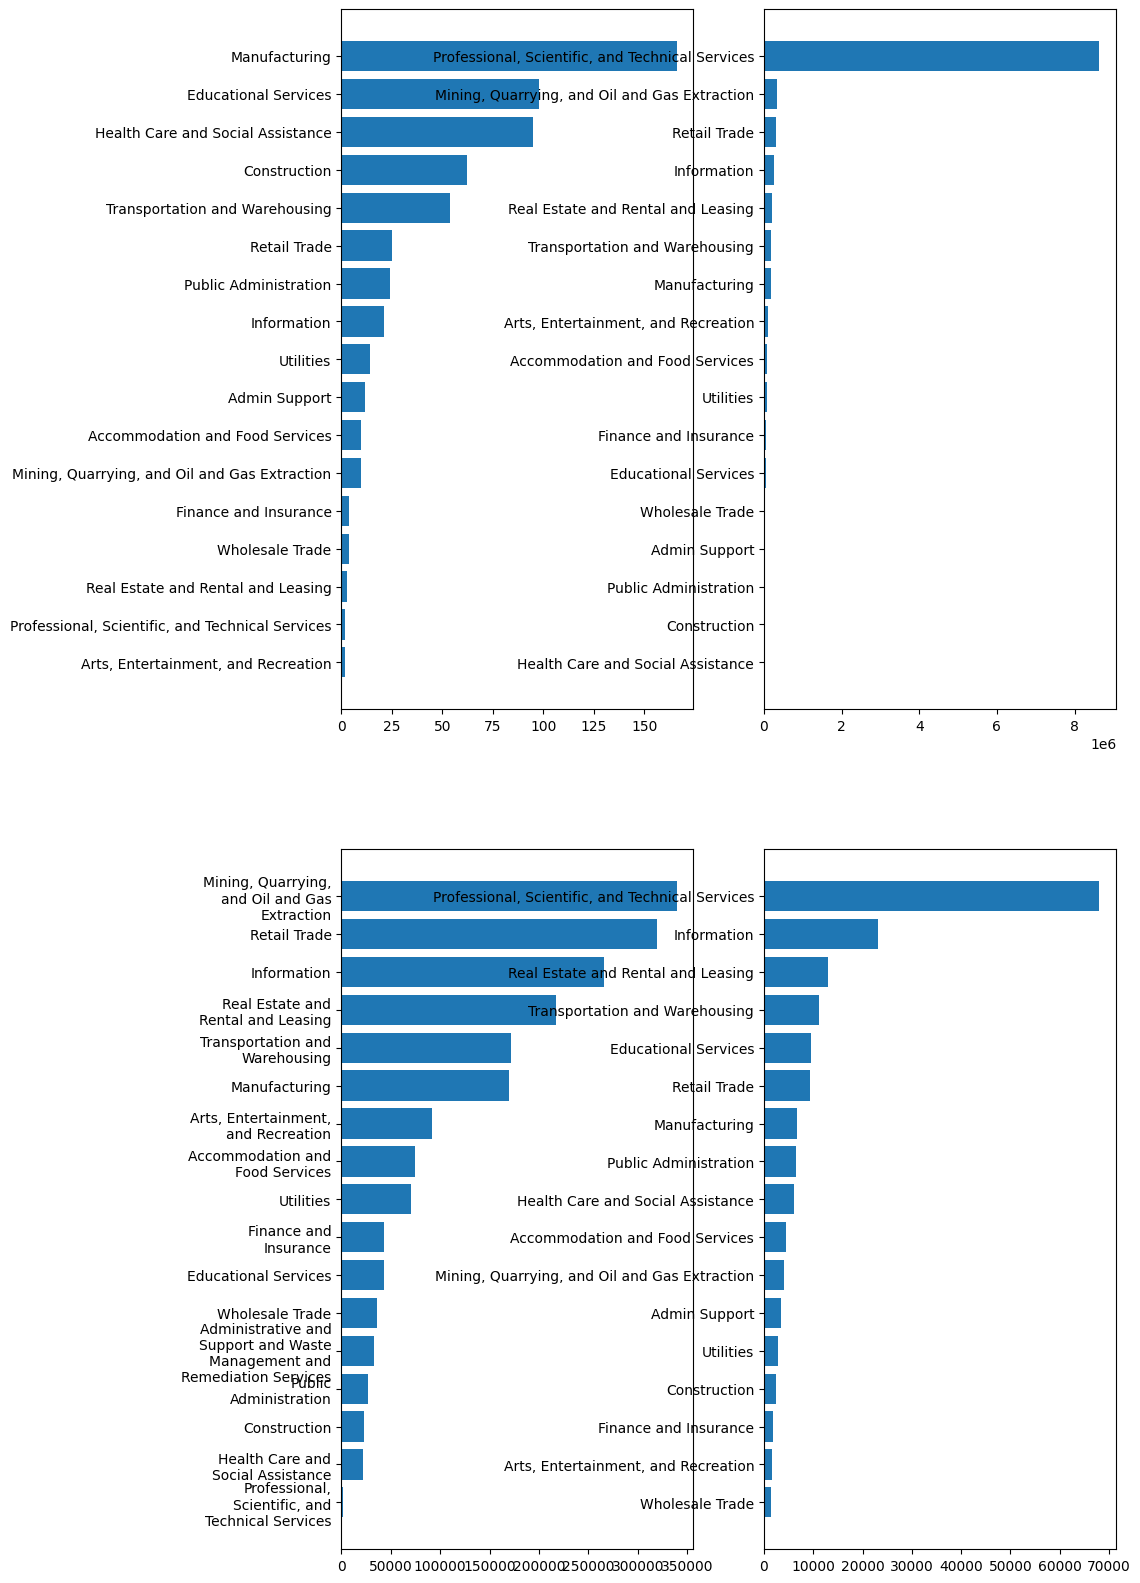

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 2)

fig.set_figheight(20)
fig.set_figwidth(10)

# grouped_by_industry['Industry'] = grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 20)))

df_sorted = grouped_by_industry.sort_values(by='Number of strikes', ascending=True)
ax1[0].barh(df_sorted['Industry'], df_sorted['Number of strikes'])
# ax1[0].xlabel('Number of strikes')
# ax1[0].ylabel('Industry')
# ax1[0].title('# Strikes by Industry')

df_sorted = grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
ax1[1].barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])

# There's one SAG-AFTRA strike where this number is an order of magnitude larger then every other entry, let's filter it out
filter_out_sag_aftra = bls_dataframe[bls_dataframe['Cumulative days idle'] < 10000000]

filtered_grouped_by_industry = filter_out_sag_aftra.groupby(['Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Industry'])


filtered_grouped_by_industry['Industry'] = filtered_grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 20)))

filtered_grouped_by_industry.columns = filtered_grouped_by_industry.columns.map(' '.join)
filtered_grouped_by_industry = filtered_grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})
filtered_grouped_by_industry.loc[filtered_grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

df_sorted = filtered_grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
ax2[0].barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# ax2[0].xlabel('Average # Days Idle')
# ax2[0].ylabel('Industry')
# ax2[0].title('Average Cumulative Days Idle by Industry (Filtered)')

df_sorted = grouped_by_industry.sort_values(by='Number of workers mean', ascending=True)
ax2[1].barh(df_sorted['Industry'], df_sorted['Number of workers mean'])
# ax2[1].xlabel('Average # Workers')
# ax2[1].ylabel('Industry')
# ax2[1].title('Average Size of Strikes by Industry')

plt.show()

In [69]:
# df_sorted = grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
# plt.barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# plt.xlabel('Average # Days Idle')
# plt.ylabel('Industry')
# plt.title('Average Cumulative Days Idle by Industry')

In [70]:

# # There's one SAG-AFTRA strike where this number is an order of magnitude larger then every other entry, let's filter it out
# filter_out_sag_aftra = bls_dataframe[bls_dataframe['Cumulative days idle'] < 10000000]

# filtered_grouped_by_industry = filter_out_sag_aftra.groupby(['Industry']).agg({
#     'Number of workers': ['sum', 'mean', 'count'],
#     'Cumulative days idle': ['sum','mean']
# }).reset_index(names=['Industry'])

# filtered_grouped_by_industry.columns = filtered_grouped_by_industry.columns.map(' '.join)
# filtered_grouped_by_industry = filtered_grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})

# df_sorted = filtered_grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
# plt.barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# plt.xlabel('Average # Days Idle')
# plt.ylabel('Industry')
# plt.title('Average Cumulative Days Idle by Industry (Filtered)')

In [71]:
# df_sorted = grouped_by_industry.sort_values(by='Number of workers mean', ascending=True)
# plt.barh(df_sorted['Industry'], df_sorted['Number of workers mean'])
# plt.xlabel('Average # Workers')
# plt.ylabel('Industry')
# plt.title('Average Size of Strikes by Industry')

In [72]:

grouped_by_year = bls_dataframe.groupby(['Year']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year'])

grouped_by_year.columns = grouped_by_year.columns.map(' '.join)
grouped_by_year = grouped_by_year.rename(columns={'Year ' : 'Year', 'Number of workers count' : 'Number of strikes'})
grouped_by_year

,Year,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,1988,2500,2500.000000,1,2879500,2.879500e+06
1,1993,181900,5197.142857,35,3597800,1.027943e+05
2,1994,324500,7211.111111,45,7948100,1.766244e+05
3,1995,190300,6343.333333,30,3476900,1.158967e+05
4,1996,272700,7370.270270,37,5246100,1.417865e+05
5,1997,338600,11675.862069,29,3527900,1.216517e+05
6,1998,386800,11376.470588,34,6692100,1.968265e+05
7,1999,72600,4270.588235,17,961000,5.652941e+04
8,2000,393700,10094.871795,39,19911500,5.105513e+05
9,2001,99100,3417.241379,29,1143200,3.942069e+04


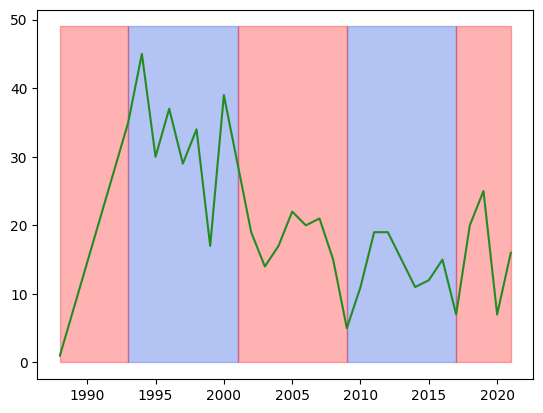

In [73]:
plt.plot(grouped_by_year['Year'], grouped_by_year['Number of strikes'], color='forestgreen')

# ax = plt.gca()
y = np.arange(0, 50)
# years with a Democratic president are shaded in blue
plt.fill_betweenx(y, 1993, 2001, alpha=0.4, color='royalblue')
plt.fill_betweenx(y, 2009, 2017, alpha=0.4, color='royalblue')

#years with a Republican president are shaded in red
plt.fill_betweenx(y, 1988, 1993, alpha=0.3, color='red')
plt.fill_betweenx(y, 2001, 2009, alpha=0.3, color='red')
plt.fill_betweenx(y, 2017, 2021, alpha=0.3, color='red')



In [74]:
grouped_by_year_and_industry = bls_dataframe[(bls_dataframe['Year'] >= 1993) & (bls_dataframe['Year'] <=2021)].groupby(['Year', 'Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year', 'Industry'])

grouped_by_year_and_industry.columns = grouped_by_year_and_industry.columns.map(' '.join)
grouped_by_year_and_industry = grouped_by_year_and_industry.rename(columns={'Industry ' : 'Industry', 'Year ': 'Year', 'Number of workers count' : 'Number of strikes'})
# grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services']['Industry'] = 'Admin Support'
grouped_by_year_and_industry.loc[grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

# industries = grouped_by_year_and_industry['Industry'].unique()
# years = grouped_by_year_and_industry['Year'].unique()

# to_add = []

# for industry in industries:
#     industry_data = grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == industry]
#     # if data doesn't exist for a particular year we want to add
#     for year in years:
#         if year not in industry_data['Year']:
#             to_append = to_add.append([year, industry,0,0,0,0,0])
#     num_strikes = grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == industry].sort_values(by='Year', ascending=True)['Number of strikes']

# df = pd.DataFrame(to_add, columns=['Year', 'Industry', 'Number of workers sum',	'Number of workers mean', 'Number of strikes', 'Cumulative days idle sum',	'Cumulative days idle mean'])
# grouped_by_year_and_industry = pd.concat([grouped_by_year_and_industry, df])
       

grouped_by_year_and_industry

,Year,Industry,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,1993,Admin Support,1800,1800.0,1,12600,12600.0
1,1993,Construction,5600,2800.0,2,45600,22800.0
2,1993,Educational Services,11500,2300.0,5,58100,11620.0
3,1993,Finance and Insurance,3400,3400.0,1,115600,115600.0
4,1993,Health Care and Social Assistance,12000,12000.0,1,12000,12000.0
...,...,...,...,...,...,...,...
205,2021,Educational Services,7200,2400.0,3,201000,67000.0
206,2021,Health Care and Social Assistance,45400,11350.0,4,118800,29700.0
207,2021,Manufacturing,16600,3320.0,5,531600,106320.0
208,2021,"Mining, Quarrying, and Oil and Gas Extraction",1100,1100.0,1,205700,205700.0


NameError: name 'industries' is not defined

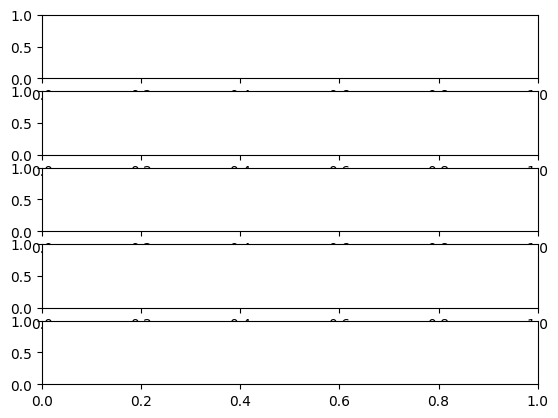

In [75]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)

for industry in industries:
    industry_data = grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == industry].sort_values(by='Year', ascending=True)
    years = industry_data['Year']

    num_strikes = industry_data['Number of strikes']
    ax1.plot(pd.Series(years), num_strikes, label=industry)

    sum_workers = industry_data['Number of workers sum']
    ax2.plot(pd.Series(years), sum_workers, label=industry)

    avg_workers = industry_data['Number of workers mean']
    ax3.plot(pd.Series(years), avg_workers, label=industry)

    days_idle_sum = industry_data['Cumulative days idle sum']
    ax4.plot(pd.Series(years), days_idle_sum, label=industry)

    days_idle_mean = industry_data['Cumulative days idle mean']
    ax5.plot(pd.Series(years), days_idle_mean, label=industry)

plt.show()

In [ ]:
filtered_grouped_by_year_and_industry = filter_out_sag_aftra[(filter_out_sag_aftra['Year'] >= 1993) & (filter_out_sag_aftra['Year'] <=2021)].groupby(['Year', 'Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year', 'Industry'])

filtered_grouped_by_year_and_industry.columns = filtered_grouped_by_year_and_industry.columns.map(' '.join)
filtered_grouped_by_year_and_industry = filtered_grouped_by_year_and_industry.rename(columns={'Industry ' : 'Industry', 'Year ': 'Year', 'Number of workers count' : 'Number of strikes'})
# filtered_grouped_by_year_and_industry[filtered_grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services']['Industry'] = 'Admin Support'
filtered_grouped_by_year_and_industry.loc[filtered_grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

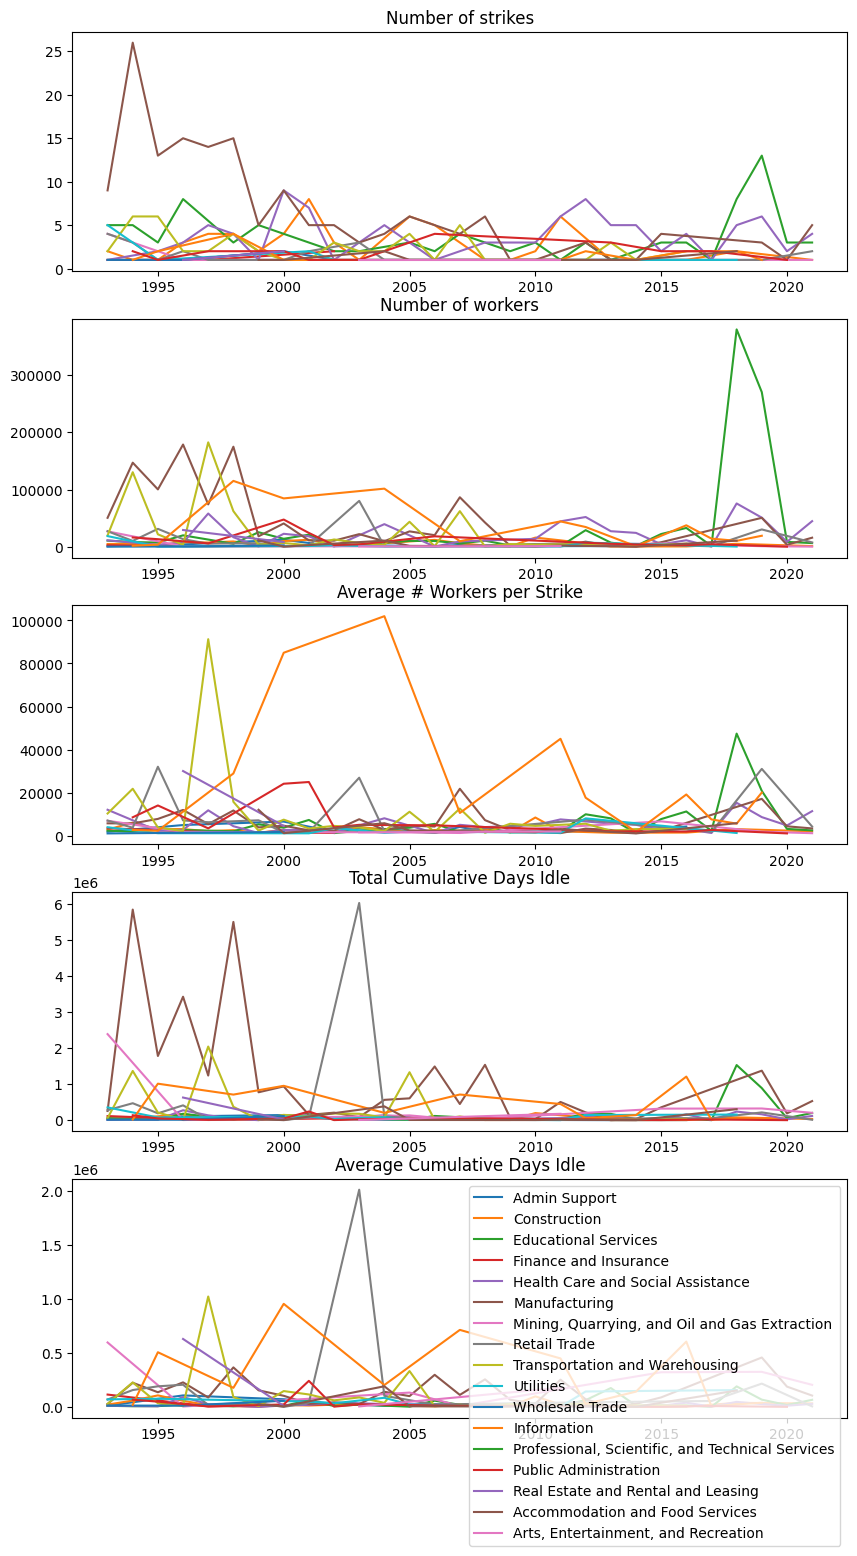

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)

fig.set_figheight(18)
fig.set_figwidth(10)

for industry in industries:
    industry_data = filtered_grouped_by_year_and_industry[filtered_grouped_by_year_and_industry['Industry'] == industry].sort_values(by='Year', ascending=True)
    years = industry_data['Year']

    num_strikes = industry_data['Number of strikes']
    ax1.plot(pd.Series(years), num_strikes, label=industry)
    ax1.set_title('Number of strikes')

    sum_workers = industry_data['Number of workers sum']
    ax2.plot(pd.Series(years), sum_workers, label=industry)
    ax2.set_title('Number of workers')

    avg_workers = industry_data['Number of workers mean']
    ax3.plot(pd.Series(years), avg_workers, label=industry)
    ax3.set_title('Average # Workers per Strike')

    days_idle_sum = industry_data['Cumulative days idle sum']
    ax4.plot(pd.Series(years), days_idle_sum, label=industry)
    ax4.set_title('Total Cumulative Days Idle')

    days_idle_mean = industry_data['Cumulative days idle mean']
    ax5.plot(pd.Series(years), days_idle_mean, label=industry)
    ax5.set_title('Average Cumulative Days Idle')

plt.legend()
plt.show()

In [ ]:
grouped_by_year_and_ownership = bls_dataframe[(bls_dataframe['Year'] >= 1993) & (bls_dataframe['Year'] <=2021)].groupby(['Year', 'Ownership']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year', 'Ownership'])

grouped_by_year_and_ownership.columns = grouped_by_year_and_ownership.columns.map(' '.join)
grouped_by_year_and_ownership = grouped_by_year_and_ownership.rename(columns={'Ownership ' : 'Ownership', 'Year ': 'Year', 'Number of workers count' : 'Number of strikes'})
# grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == 'Administrative and Support and Waste Management and Remediation Services']['Ownership'] = 'Admin Support'
# grouped_by_year_and_ownership.loc[grouped_by_year_and_ownership['Ownership'] == 'Administrative and Support and Waste Management and Remediation Services', 'Ownership'] = 'Admin Support'

ownership_types = grouped_by_year_and_ownership['Ownership'].unique()
years = grouped_by_year_and_ownership['Year'].unique()

# to_add = []

# for ownership_type in ownership_types:
#     ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type]
#     # if data doesn't exist for a particular year we want to add
#     for year in years:
#         if year not in ownership_data['Year']:
#             to_append = to_add.append([year, ownership_type,0,0,0,0,0])

# df = pd.DataFrame(to_add, columns=['Year', 'Ownership', 'Number of workers sum', 'Number of workers mean', 'Number of strikes', 'Cumulative days idle sum',	'Cumulative days idle mean'])
# grouped_by_year_and_ownership = pd.concat([grouped_by_year_and_ownership, df])
       

grouped_by_year_and_ownership

C:\Users\emmaf\AppData\Local\Temp\ipykernel_34028\3550410052.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Year,Ownership,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,1993,Local government,18600,3720.000000,5,104500,20900.000000
1,1993,Private industry,161400,5565.517241,29,3485700,120196.551724
2,1993,State and local government,0,NaN,0,0,NaN
3,1993,State government,1900,1900.000000,1,7600,7600.000000
4,1994,Local government,22800,2850.000000,8,96600,12075.000000
...,...,...,...,...,...,...,...
111,2020,State government,5700,2850.000000,2,45700,22850.000000
112,2021,Local government,2000,2000.000000,1,22000,22000.000000
113,2021,Private industry,78700,5246.666667,15,1081700,72113.333333
114,2021,State and local government,0,NaN,0,0,NaN


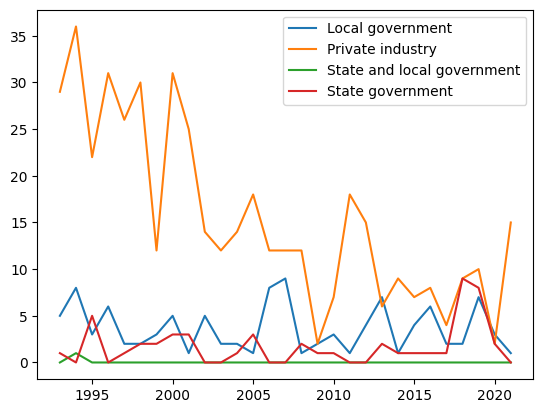

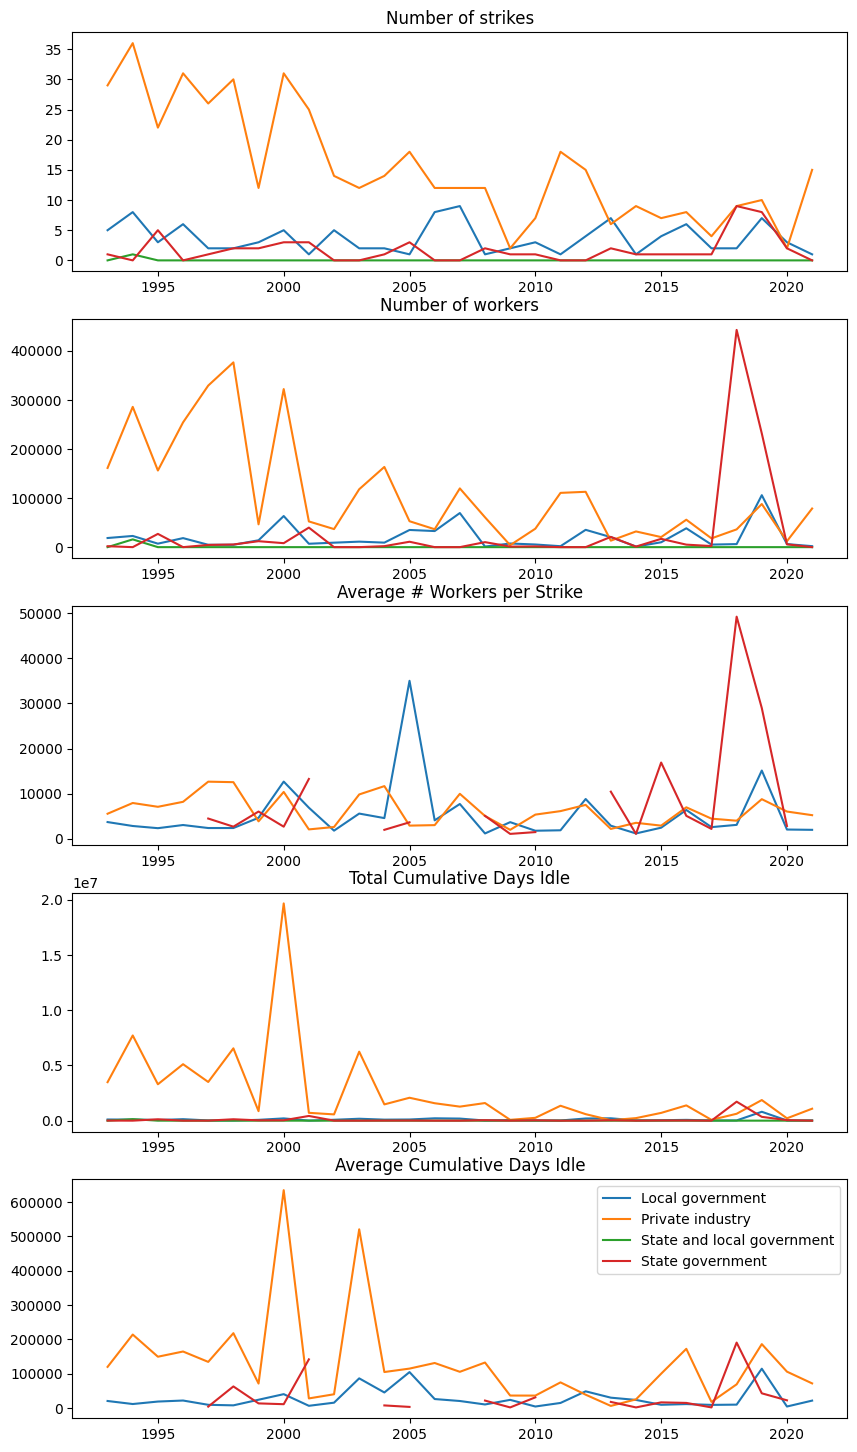

In [ ]:
for ownership_type in ownership_types:
    ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type].sort_values(by='Year', ascending=True)
    years = ownership_data['Year']
    num_strikes = ownership_data['Number of strikes']
    plt.plot(pd.Series(years), num_strikes, label=ownership_type)

plt.legend()
plt.show()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)

fig.set_figheight(18)
fig.set_figwidth(10)

for ownership_type in ownership_types:
    ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type].sort_values(by='Year', ascending=True)
    years = ownership_data['Year']

    num_strikes = ownership_data['Number of strikes']
    ax1.plot(pd.Series(years), num_strikes, label=ownership_type)
    ax1.set_title('Number of strikes')

    sum_workers = ownership_data['Number of workers sum']
    ax2.plot(pd.Series(years), sum_workers, label=ownership_type)
    ax2.set_title('Number of workers')

    avg_workers = ownership_data['Number of workers mean']
    ax3.plot(pd.Series(years), avg_workers, label=ownership_type)
    ax3.set_title('Average # Workers per Strike')

    days_idle_sum = ownership_data['Cumulative days idle sum']
    ax4.plot(pd.Series(years), days_idle_sum, label=ownership_type)
    ax4.set_title('Total Cumulative Days Idle')

    days_idle_mean = ownership_data['Cumulative days idle mean']
    ax5.plot(pd.Series(years), days_idle_mean, label=ownership_type)
    ax5.set_title('Average Cumulative Days Idle')

plt.legend()
plt.show()

In [ ]:
grouped_by_industry = bls_dataframe.groupby(['Industry']).agg({
    'Number of workers': ['mean', 'count'],
    'Cumulative days idle': 'mean',
    'Length (days)': 'mean'
}).reset_index(names=['Industry'])

grouped_by_industry.columns = grouped_by_industry.columns.map(' '.join)
grouped_by_industry = grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})
grouped_by_industry

,Industry,Number of workers mean,Number of strikes,Cumulative days idle mean,Length (days) mean
0,Accommodation and Food Services,4400.000000,10,7.511000e+04,20.000000
1,Administrative and Support and Waste Managemen...,3425.000000,12,3.308333e+04,12.583333
2,"Arts, Entertainment, and Recreation",1700.000000,2,9.230000e+04,69.000000
3,Construction,2448.387097,62,2.281452e+04,14.177419
4,Educational Services,9585.714286,98,4.298061e+04,8.206186
5,Finance and Insurance,1875.000000,4,4.340000e+04,26.000000
6,Health Care and Social Assistance,6051.578947,95,2.187789e+04,10.115789
7,Information,23157.142857,21,2.658905e+05,52.500000
8,Manufacturing,6771.084337,166,1.697602e+05,53.150602
9,"Mining, Quarrying, and Oil and Gas Extraction",4150.000000,10,3.393100e+05,94.222222


C:\Users\emmaf\AppData\Local\Temp\ipykernel_26592\870297898.py:41: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



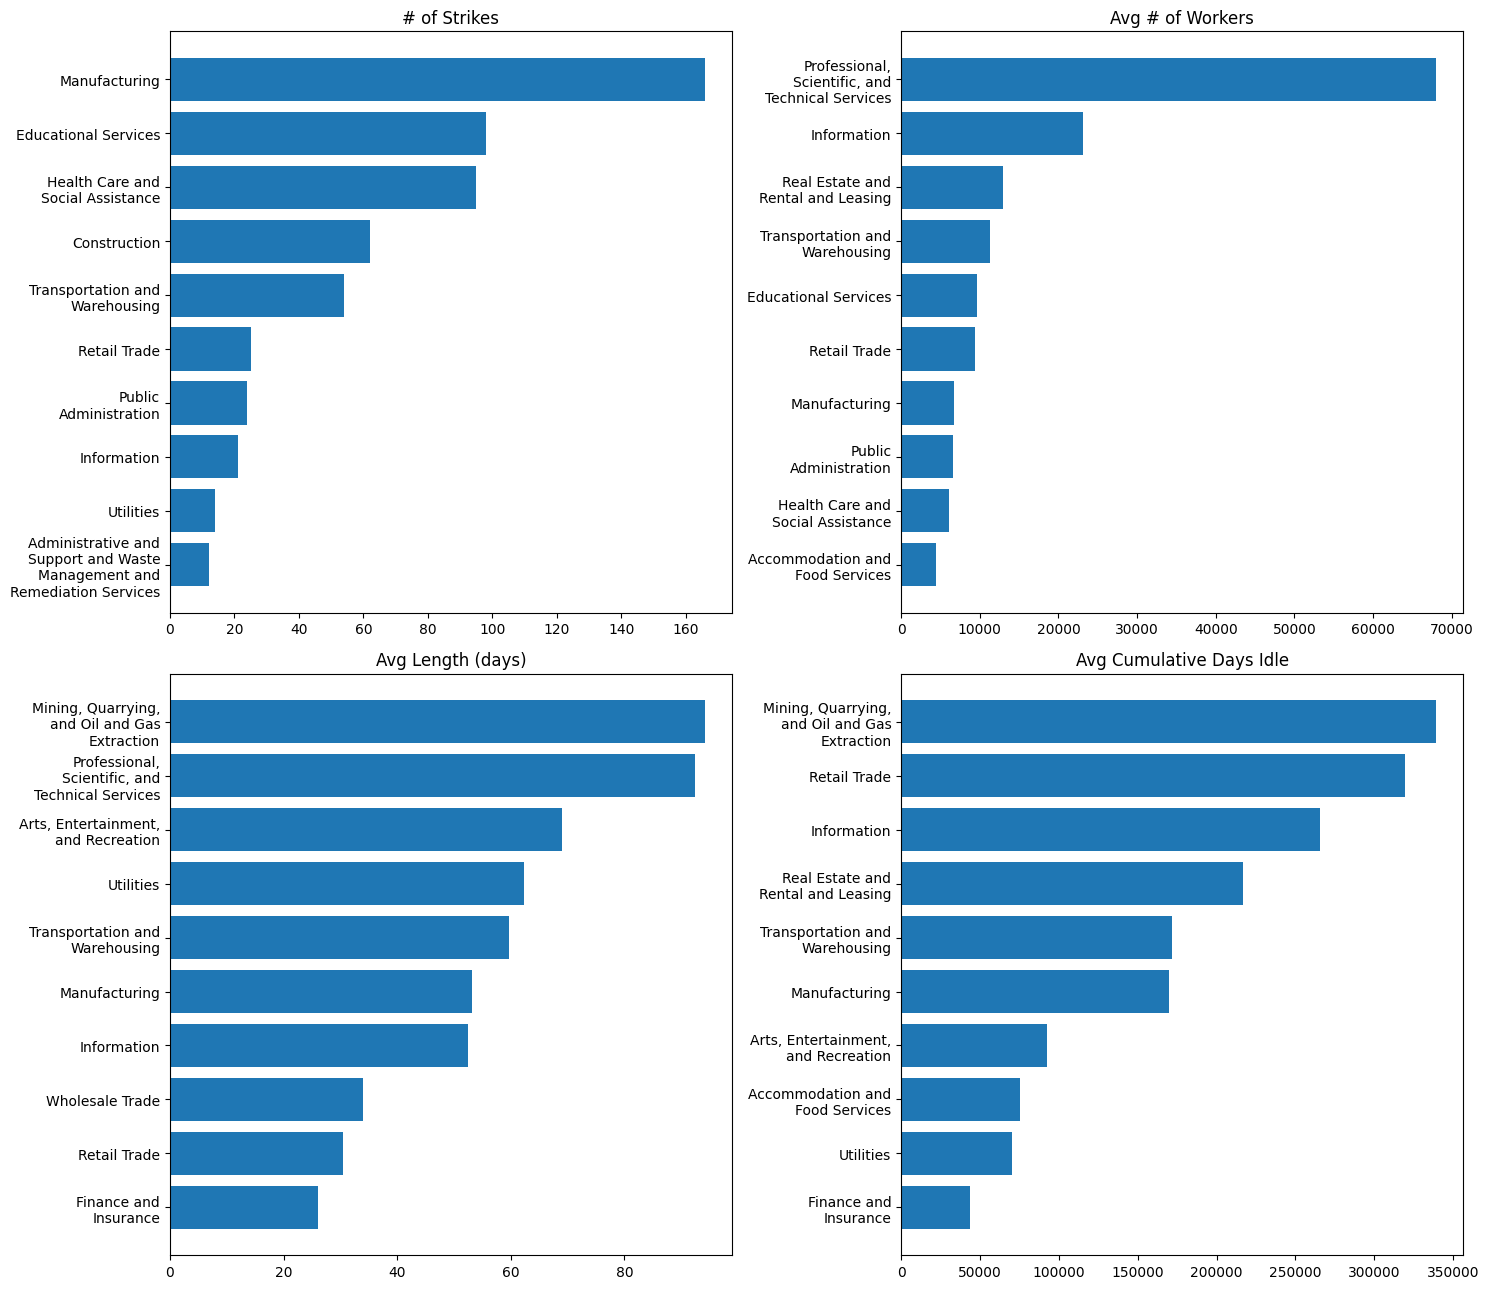

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

num = 10

grouped_by_industry['Industry'] = grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 20)))

df_sorted = grouped_by_industry.sort_values(by='Number of strikes', ascending=True).tail(num)
ax1.barh(df_sorted['Industry'], df_sorted['Number of strikes'])
ax1.set_title('# of Strikes')

df_sorted = grouped_by_industry.sort_values(by='Number of workers mean', ascending=True).tail(num)
ax2.barh(df_sorted['Industry'], df_sorted['Number of workers mean'])
ax2.set_title('Avg # of Workers')

df_sorted = grouped_by_industry.sort_values(by='Length (days) mean', ascending=True).tail(num)
ax3.barh(df_sorted['Industry'], df_sorted['Length (days) mean'])
ax3.set_title('Avg Length (days)')

# There's one SAG-AFTRA strike where this number is an order of magnitude larger then every other entry, let's filter it out for this graph
filter_out_sag_aftra = bls_dataframe[bls_dataframe['Cumulative days idle'] < 10000000]

filtered_grouped_by_industry = filter_out_sag_aftra.groupby(['Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Industry'])

filtered_grouped_by_industry['Industry'] = filtered_grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 20)))

filtered_grouped_by_industry.columns = filtered_grouped_by_industry.columns.map(' '.join)
filtered_grouped_by_industry = filtered_grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})
filtered_grouped_by_industry.loc[filtered_grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

df_sorted = filtered_grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True).tail(num)
ax4.barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
ax4.set_title('Avg Cumulative Days Idle')

fig.set_figwidth(15)
fig.set_figheight(13)
fig.tight_layout()
# fig.subplots_adjust(wspace=0.5)
fig.show()

In [ ]:
# Some strikes affected more than one state at once; for example the Boeing strike of 2008 affected Washington, Oregon, and Kansas
# This is recorded in the CSV as a single row, with the States column saying "WA, OR, KS". If we want to do a groupby based on states, 
# we'll want to split (or 'explode') that into three mostly-identical rows, one for each state.
bls_dataframe_exploded_by_states = bls_dataframe.explode(column='States')

# Some strikes don't list a state, or simply say things like 'Interstate' or 'East coast states.' We can't use that to build choropleths,
# So we'll have to exclude these
bls_dataframe_exploded_by_states = bls_dataframe_exploded_by_states[bls_dataframe_exploded_by_states['States'].str.len() == 2]

bls_dataframe_exploded_by_states

In [ ]:
grouped_by_state = bls_dataframe_exploded_by_states.groupby('States').agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean'],
    'Length (days)': ['mean']
}).reset_index(names=['States'])

grouped_by_state.columns = grouped_by_state.columns.map(' '.join)
grouped_by_state = grouped_by_state.rename(columns={'States ' : 'State', 'Number of workers count' : 'Number of strikes'})

grouped_by_state

In [ ]:
colorscale = px.colors.sequential.Inferno

fig1 = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of strikes', 
    hover_name='Number of strikes',
    color_continuous_scale=colorscale,
    scope='usa')

fig1.update_layout(title='Total Count')

fig2 = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers mean', 
    hover_name='State',
    color_continuous_scale=colorscale,
    scope='usa')


fig2.update_layout(title='Average Number of Workers')

fig3 = px.choropleth(grouped_by_state, #[grouped_by_state['Length (days) mean'] <= 365], 
    locations='State', 
    locationmode='USA-states', 
    color='Length (days) mean', 
    hover_name='Length (days) mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig3.update_layout(title='Average Length (days)')

fig4 = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig4.update_layout(title='Average Cumulative days idle')

fig_subplots = ipw.VBox([
    ipw.HBox([go.FigureWidget(fig1),go.FigureWidget(fig2)]),
    ipw.HBox([go.FigureWidget(fig3),go.FigureWidget(fig4)])
])

display(ipw.HTML("<h2>Work Stoppages 1993-2021 by State</h2>"))
display(fig_subplots)

In [ ]:
colorscale = px.colors.sequential.Inferno

grouped_by_state_above_threshold = grouped_by_state[grouped_by_state['Number of strikes'] >= 10]

fig1 = px.choropleth(grouped_by_state_above_threshold, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of strikes', 
    hover_name='Number of strikes',
    color_continuous_scale=colorscale,
    scope='usa')

fig1.update_layout(title='Total Count')

fig2 = px.choropleth(grouped_by_state_above_threshold, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers mean', 
    hover_name='State',
    color_continuous_scale=colorscale,
    scope='usa')


fig2.update_layout(title='Average Number of Workers')

fig3 = px.choropleth(grouped_by_state_above_threshold, #[grouped_by_state['Length (days) mean'] <= 365], 
    locations='State', 
    locationmode='USA-states', 
    color='Length (days) mean', 
    hover_name='Length (days) mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig3.update_layout(title='Average Length (days)')

fig4 = px.choropleth(grouped_by_state_above_threshold, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig4.update_layout(title='Average Cumulative days idle')

fig_subplots = ipw.VBox([
    ipw.HBox([go.FigureWidget(fig1),go.FigureWidget(fig2)]),
    ipw.HBox([go.FigureWidget(fig3),go.FigureWidget(fig4)])
])

display(ipw.HTML("<h2>Work Stoppages 1993-2021 by State</h2>"))
display(fig_subplots)